# Stock market trends and Value at Risk

Author: Jesse Lima <jaglima1984@gmail.com>

---

**Warning**: This study there is no purposes of financial advice or investment analysis.

In [19]:
%matplotlib inline
import pyfolio as pf
import matplotlib.pyplot as plt
import numpy
import ffn
import numpy as np
import pandas as pd
# silence warnings
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

def clean(prices, ini, end):
    prices = prices.sort_index()
    idx = pd.date_range(ini, end)
    prices = prices.reindex(idx, fill_value=np.nan)
    prices = prices.interpolate('linear')
    
    return prices


ini = '20150102'
end = '20171231'

# Loading and cleaning the time serie
df1 = pd.read_csv('btc_usd.csv', dayfirst=True, parse_dates=True, index_col=[0])
prices = clean(df1, ini, end)
prices = prices['BTC-USD']
ret = prices.pct_change().dropna()

# Loading the risk free curve
#rf_curve = pd.read_csv('riskFreeTreasure.csv', dayfirst=True, parse_dates=True, index_col=[0] )
#rf_curve = clean(rf_curve, ini, end)
#ret_rf = ret_rf
#ret_rf = ret_rf.dropna()

## Stock market returns and volatility

Let's download some stock market data for Microsoft (stock market ticker is `MSFT`) for the year 2013 and plot its evolution over time.

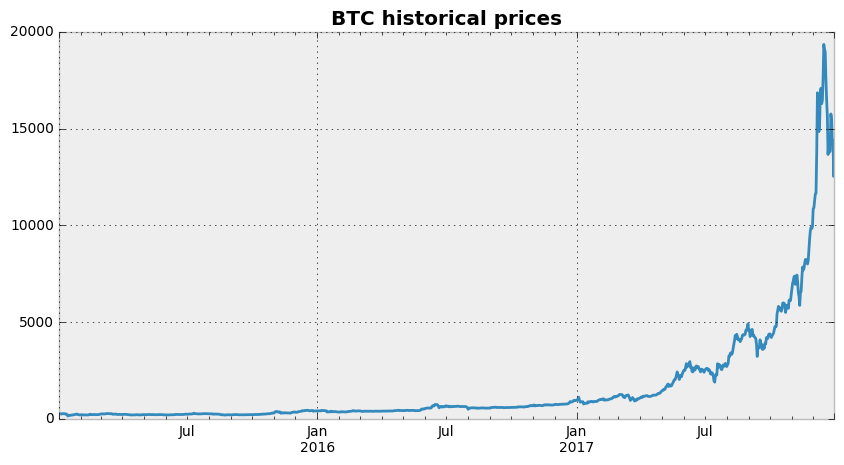

In [7]:
# Download BTC vs USD time serie from quandl API
# Just getting Close prices
#prices = quandl.get("BCHARTS/BITSTAMPUSD")['Close']

fig = plt.figure()
fig.set_size_inches(10,5)
prices = prices[(prices != 0) & (prices !=numpy.nan) & (prices != numpy.inf)]

prices.plot()
plt.title(u"BTC historical prices", weight='bold');

For risk analysis we are more interested in daily changes than in the absolute value of the stock, so we plot the daily returns on the stock.

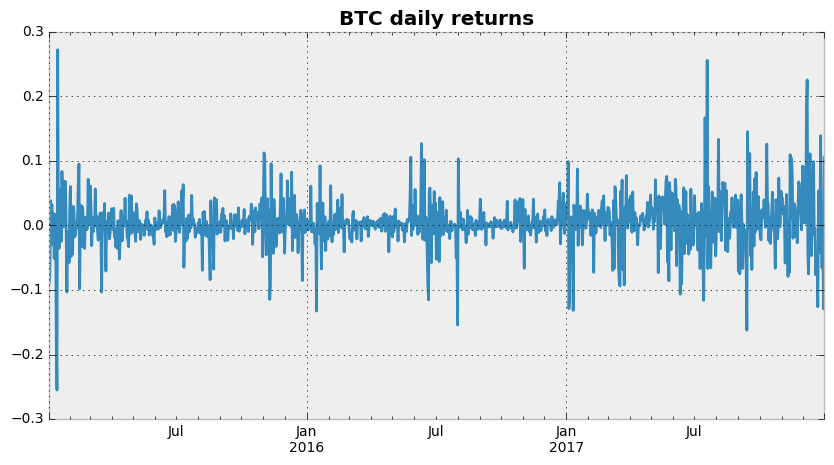

In [20]:
fig = plt.figure()
fig.set_size_inches(10,5)
ret.plot()
plt.title(u"BTC daily returns", weight='bold');

0.038918986969136794

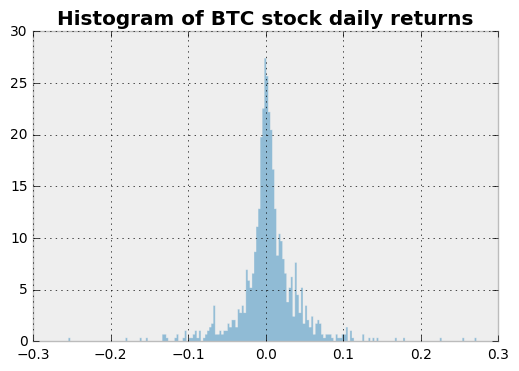

In [21]:
ret.hist(bins=200, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of BTC stock daily returns", weight='bold')
ret.std()

Let's see whether the daily returns are better represented by a normal distribution or by a Student-t distribution.

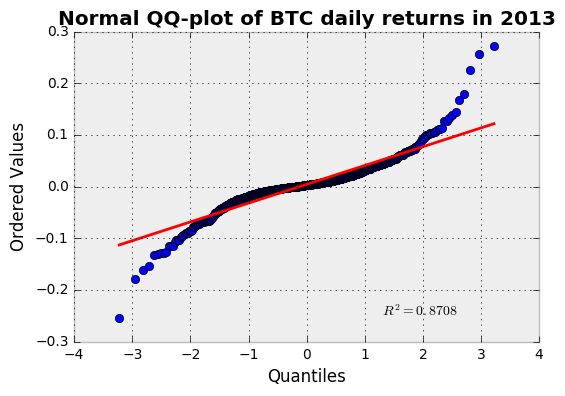

In [22]:
Q = ret.dropna().as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of BTC daily returns in 2013", weight="bold");

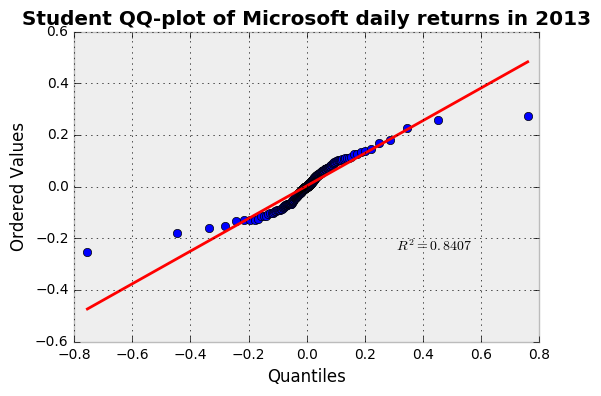

In [12]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Microsoft daily returns in 2013", weight="bold");

Student's t distribution does seem to fit better (look in particular at the tails of the distribution).

## Value at Risk using the historical bootstrap method

Method: we calculate **empirical quantiles** from a histogram of daily returns. Let's do that for the returns over 2013-2014.

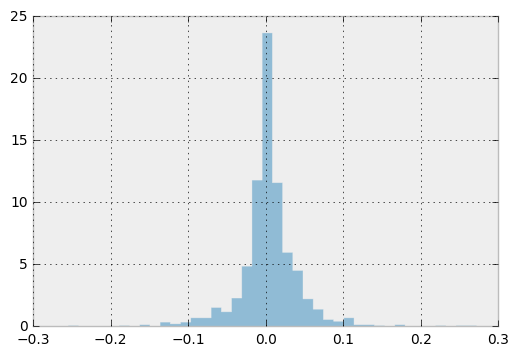

In [26]:
mean = ret.mean()
sigma = ret.std()
tdf, tmean, tsigma = scipy.stats.t.fit(ret.as_matrix())
ret.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);

In [27]:
ret.quantile(0.05)

-0.061206542896629218

The 0.05 empirical quantile of daily returns is at -0.070. That means that with 95% confidence, our worst daily loss will not exceed 7.0%. If we have a 1BTC investment, our one-day 5% VaR is 0.070 * 1BTC = 0.07BTC.

## Value at Risk using the variance-covariance method

Method: calculate analytic quantiles by curve fitting to historical data. Here, we use Student's t distribution (we checked above that it represents daily returns relatively well).

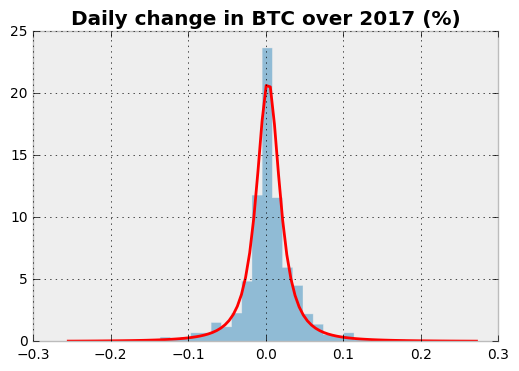

In [30]:
support = numpy.linspace(ret.min(), ret.max(), 100)
ret.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in BTC over 2017 (%)", weight='bold');

In [31]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.059797771523891263

Our analytic 0.05 quantile is at -0.0938, so with 95% confidence, our worst daily loss will not exceed 9.38%. For a 1BTC investment, one-day Value at Risk is 0.0938 * 1BTC = 0.093 BTC.

## Applying values over time

Lets apply the methodology over BTC returns using moving windows to backtest the adherence of method.

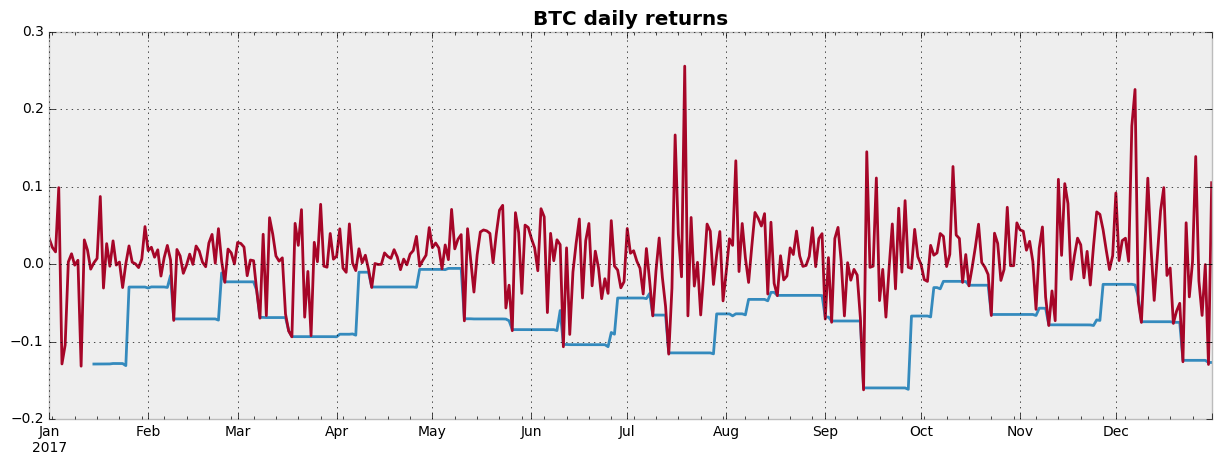

In [33]:
def risk_var(ret, window=30, alpha=0.98, per=0.05):
    
    def var(returns):
        data = DataFrame(returns).ewm(alpha=alpha).mean()
        return numpy.percentile(data, per)

    return ret.rolling(window).apply(lambda x : var(x))
    
    

start = '2017-01'
end   = '2017-12'
returns = ret[start:end]

risk = risk_var(returns, window=15)

fig = plt.figure()
fig.set_size_inches(15,5)
risk.plot()
returns.plot()
plt.title(u"BTC daily returns", weight='bold');



## Backtest

Based on results until now, lets backtest the results when applying Value At Risk on BTC daily returns in 2017, checking when the realized loss surpassed the expected loss from model. 

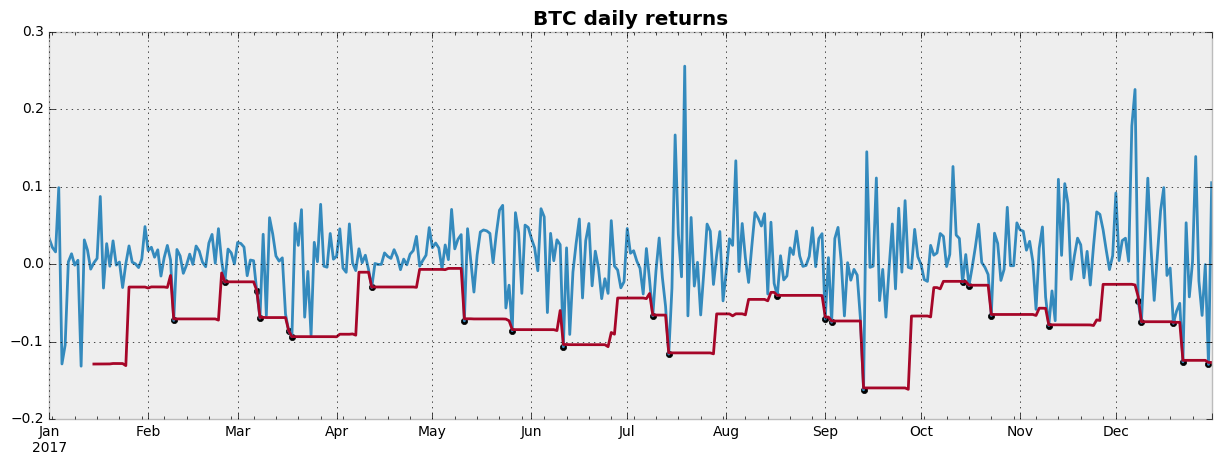

In [39]:
start = '2017-01'
end   = '2017-12'
returns = ret[start:end]

window = 30
loss = risk_var(returns, window=15)

fails = returns[(returns < 0) & (returns < loss)]

fig = plt.figure()
fig.set_size_inches(15,5)
returns.plot()
loss.plot()
plt.scatter(fails.index, fails.values, color='k')
plt.title(u"BTC daily returns", weight='bold');

From above figure, it  is possible to conclude that the window size has direct impact on the loss expectative obtaind from model. 

In [40]:
float(fails.count())/float(returns.count())*100


6.8493150684931505

In the backtest, the model failed 7% on the times estimating the maximum loss for next day return.

## Day-to-day results

In [41]:
portfolio_size = 1.3
today_risk = returns.tail(30)
today_risk.quantile(0.05)*portfolio_size*float(prices.tail(1))

-1864.861601081064